# Grouped Regression Charts

Group-by operations can be applied in other contexts such as regression models. In this notebook, we use layered charts in Altair to combine an original data set with a regression model, both of which are grouped by a categorial column. Future versions of Altair are likely to have regression charts built in; this notebook provides one possible way we could spell out that API.

## Imports

In [1]:
from altair import *
import numpy as np
import pandas as pd

## Data

Here is a function that creates x/y data with an additional categorical column we will use for grouping the data:

In [2]:
def make_data(N, rseed=42):
    rng = np.random.RandomState(rseed)
    x = 100 * rng.rand(N)
    c = rng.randint(0, 3, N)
    y = (c - 2) * x + (10 + 0.2 * x) * rng.randn(N)
    return pd.DataFrame({'x': x, 'y': y, 'c': c})

In [3]:
data = make_data(100)
data.head()

,c,x,y
0,2,37.454012,29.849890
1,2,95.071431,25.346573
2,0,73.199394,-146.173473
3,0,59.865848,-127.763754
4,1,15.601864,-7.085604


## Specializing `Chart`

Here we specialize `Chart` and add a method which computes a grouped regression model for two columns of the original dataset.

In [4]:
import altair
from copy import deepcopy


def linear_regression(x, y):
    """Return the linear regression of y at x"""
    p = np.polyfit(x, y, 1)
    return np.polyval(p, x)


class Chart(altair.Chart):
    @staticmethod
    def _add_regression_column(group, regression_func, x, y, yfit):
        group[yfit] = regression_func(group[x], group[y])
        return group
    
    def regression_plot(self, func=linear_regression):
        if not isinstance(self.data, pd.DataFrame):
            raise ValueError("regress() requires data to be specified as pandas DataFrame")

        points = self.mark_point()
        
        encoding = points.encoding.to_dict()
        if any(enc.get('bin', None) for enc in encoding.values()):
            raise ValueError("regress() cannot handle binned variables")

        group_cols = [enc['field'] for key, enc in encoding.items()
                      if key not in ['x', 'y']]
        x = encoding['x']['field']
        y = encoding['y']['field']
        yfit = y + '_fit'

        if group_cols:
            groups = self.data.groupby(group_cols)
            data = groups.apply(self._add_regression_column,
                                regression_func=func,
                                x=x, y=y, yfit=yfit)
        else:
            data = self._add_regression_column(self.data.copy(),
                                               regression_func=func,
                                               x='x', y='y', yfit='y_fit')

        lines = deepcopy(self).mark_line().encode(y=yfit)
        lines.data = data

        return LayeredChart(data).set_layers(points, lines)

## Global regression

First we do a global regression plot across all categorical values:

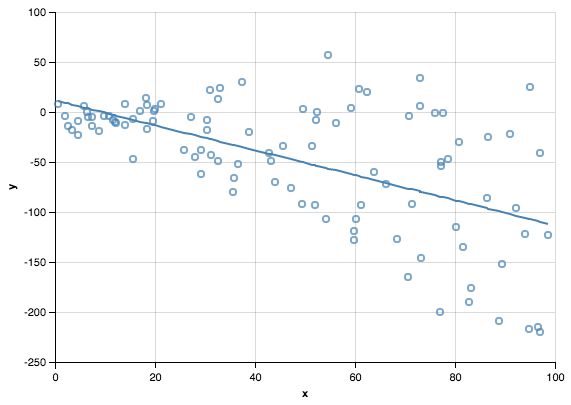

In [5]:
Chart(data).encode(
    x='x',
    y='y',
).regression_plot()

## Grouped regression

Next, we provide a color and the regression model is applied separately to each group:

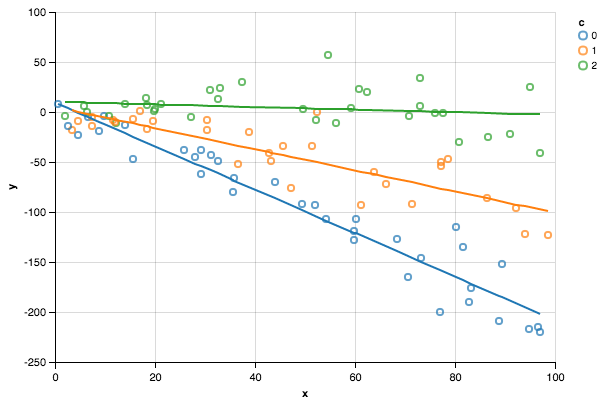

In [6]:
Chart(data).encode(
    x='x',
    y='y',
    color='c:N',
).regression_plot()

## Cubic regression

Here we show how a different model can be passed into the the regression plot, with the groups still being respected:

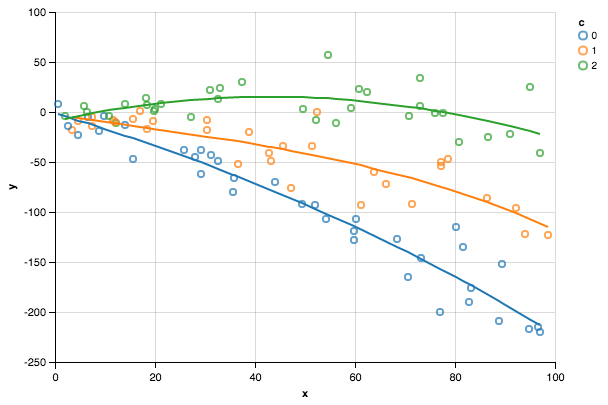

In [7]:
def cubic_regression(x, y):
    p = np.polyfit(x, y, 3)
    return np.polyval(p, x)

Chart(data).encode(
    x='x',
    y='y',
    color='c:N',
).regression_plot(cubic_regression)